In [62]:
import pandas as pd
import typing
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from scipy.signal import butter, filtfilt
from time import time

In [63]:
tf.config.list_physical_devices('GPU')

[]

In [64]:
df = pd.read_csv('data/solar_temp_austin/solar_temp.csv', sep=",")
df

,WABANNO,UTC_DATE,UTC_TIME,LST_DATE,LST_TIME,CRX_VN,LONG,LAT,AIR_TEMP,PERCP,SOLAR_RAD,SR_FLAG,SURFACE_TEMP,ST_TYPE,ST_FLAG,RELATIVE_HUMIDITY,RH_FLAG,WIND_1_5,WIND_FLAG
0,23907,20230101,5,20221231,1805,2.623,-98.08,30.62,20.0,0,0,0,16.9,C,0,39,0,2.94,0
1,23907,20230101,10,20221231,1810,2.623,-98.08,30.62,19.9,0,0,0,16.7,C,0,39,0,2.37,0
2,23907,20230101,15,20221231,1815,2.623,-98.08,30.62,19.7,0,0,0,16.5,C,0,40,0,2.54,0
3,23907,20230101,20,20221231,1820,2.623,-98.08,30.62,19.7,0,0,0,16.5,C,0,40,0,2.99,0
4,23907,20230101,25,20221231,1825,2.623,-98.08,30.62,19.7,0,0,0,16.4,C,0,39,0,2.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38323,23907,20230514,140,20230513,1940,2.623,-98.08,30.62,19.4,0,0,0,20.7,C,0,90,0,1.57,0
38324,23907,20230514,145,20230513,1945,2.623,-98.08,30.62,19.3,0,0,0,20.5,C,0,90,0,1.28,0
38325,23907,20230514,150,20230513,1950,2.623,-98.08,30.62,19.2,0,0,0,20.4,C,0,90,0,1.41,0
38326,23907,20230514,155,20230513,1955,2.623,-98.08,30.62,19.2,0,0,0,20.3,C,0,90,0,1.47,0


In [65]:
df['datetime'] = df['UTC_DATE'].astype(str) + df['UTC_TIME'].astype(str).str.zfill(4)
# convert the combined column to datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d%H%M')
# set the datetime column as the index
df.set_index('datetime', inplace=True)
# drop the 'UTC_DATE' and 'UTC_TIME' columns
df = df.drop(['UTC_DATE', 'UTC_TIME', 'WABANNO', 'LST_DATE', 'CRX_VN', 'LONG', 'LAT'], axis=1)
df


,LST_TIME,AIR_TEMP,PERCP,SOLAR_RAD,SR_FLAG,SURFACE_TEMP,ST_TYPE,ST_FLAG,RELATIVE_HUMIDITY,RH_FLAG,WIND_1_5,WIND_FLAG
datetime,,,,,,,,,,,,
2023-01-01 00:05:00,1805,20.0,0,0,0,16.9,C,0,39,0,2.94,0
2023-01-01 00:10:00,1810,19.9,0,0,0,16.7,C,0,39,0,2.37,0
2023-01-01 00:15:00,1815,19.7,0,0,0,16.5,C,0,40,0,2.54,0
2023-01-01 00:20:00,1820,19.7,0,0,0,16.5,C,0,40,0,2.99,0
2023-01-01 00:25:00,1825,19.7,0,0,0,16.4,C,0,39,0,2.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-14 01:40:00,1940,19.4,0,0,0,20.7,C,0,90,0,1.57,0
2023-05-14 01:45:00,1945,19.3,0,0,0,20.5,C,0,90,0,1.28,0
2023-05-14 01:50:00,1950,19.2,0,0,0,20.4,C,0,90,0,1.41,0


remove any erronous data where a flag is set to 3

In [66]:
df = df[~((df['SR_FLAG'] == 3) | (df['ST_FLAG'] == 3) | (df['RH_FLAG'] == 3) | (df['WIND_FLAG'] == 3))]
df.shape

(38268, 12)

drop all flag coloumns and  ST_TYPE and ST. Our aim is to use AIR_TEMP

In [67]:
df = df.drop(['SR_FLAG', 'ST_FLAG', 'RH_FLAG', 'WIND_FLAG', 'ST_TYPE', 'SURFACE_TEMP'], axis=1)
df

,LST_TIME,AIR_TEMP,PERCP,SOLAR_RAD,RELATIVE_HUMIDITY,WIND_1_5
datetime,,,,,,
2023-01-01 00:05:00,1805,20.0,0,0,39,2.94
2023-01-01 00:10:00,1810,19.9,0,0,39,2.37
2023-01-01 00:15:00,1815,19.7,0,0,40,2.54
2023-01-01 00:20:00,1820,19.7,0,0,40,2.99
2023-01-01 00:25:00,1825,19.7,0,0,39,2.80
...,...,...,...,...,...,...
2023-05-14 01:40:00,1940,19.4,0,0,90,1.57
2023-05-14 01:45:00,1945,19.3,0,0,90,1.28
2023-05-14 01:50:00,1950,19.2,0,0,90,1.41


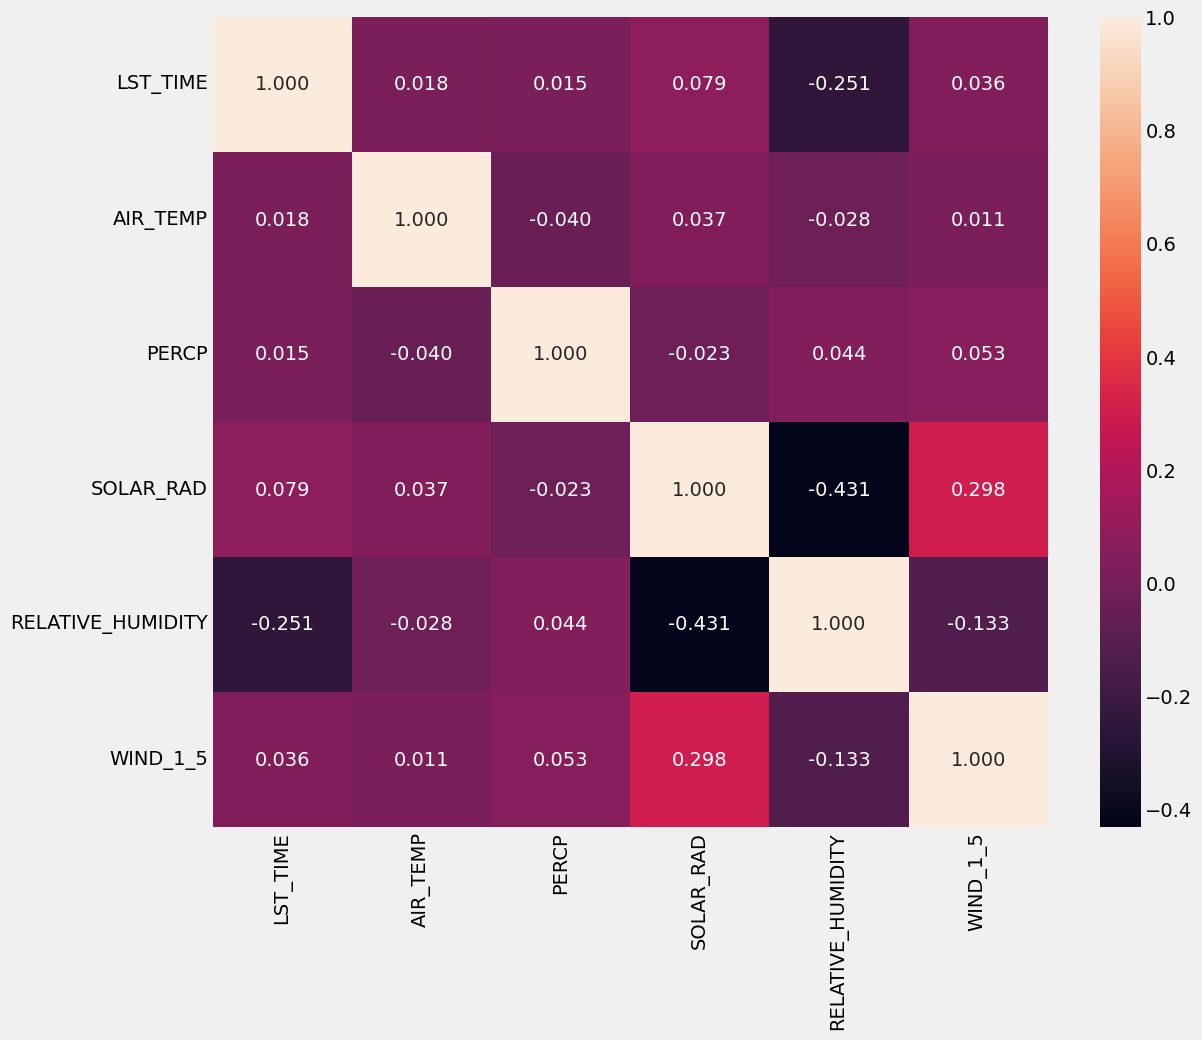

In [68]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)
corrMatrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrMatrix, annot= True, ax=ax, fmt='.3f')
plt.show()

In [69]:
df = df[~(df['AIR_TEMP']==-9999)] # remove unexpected small values

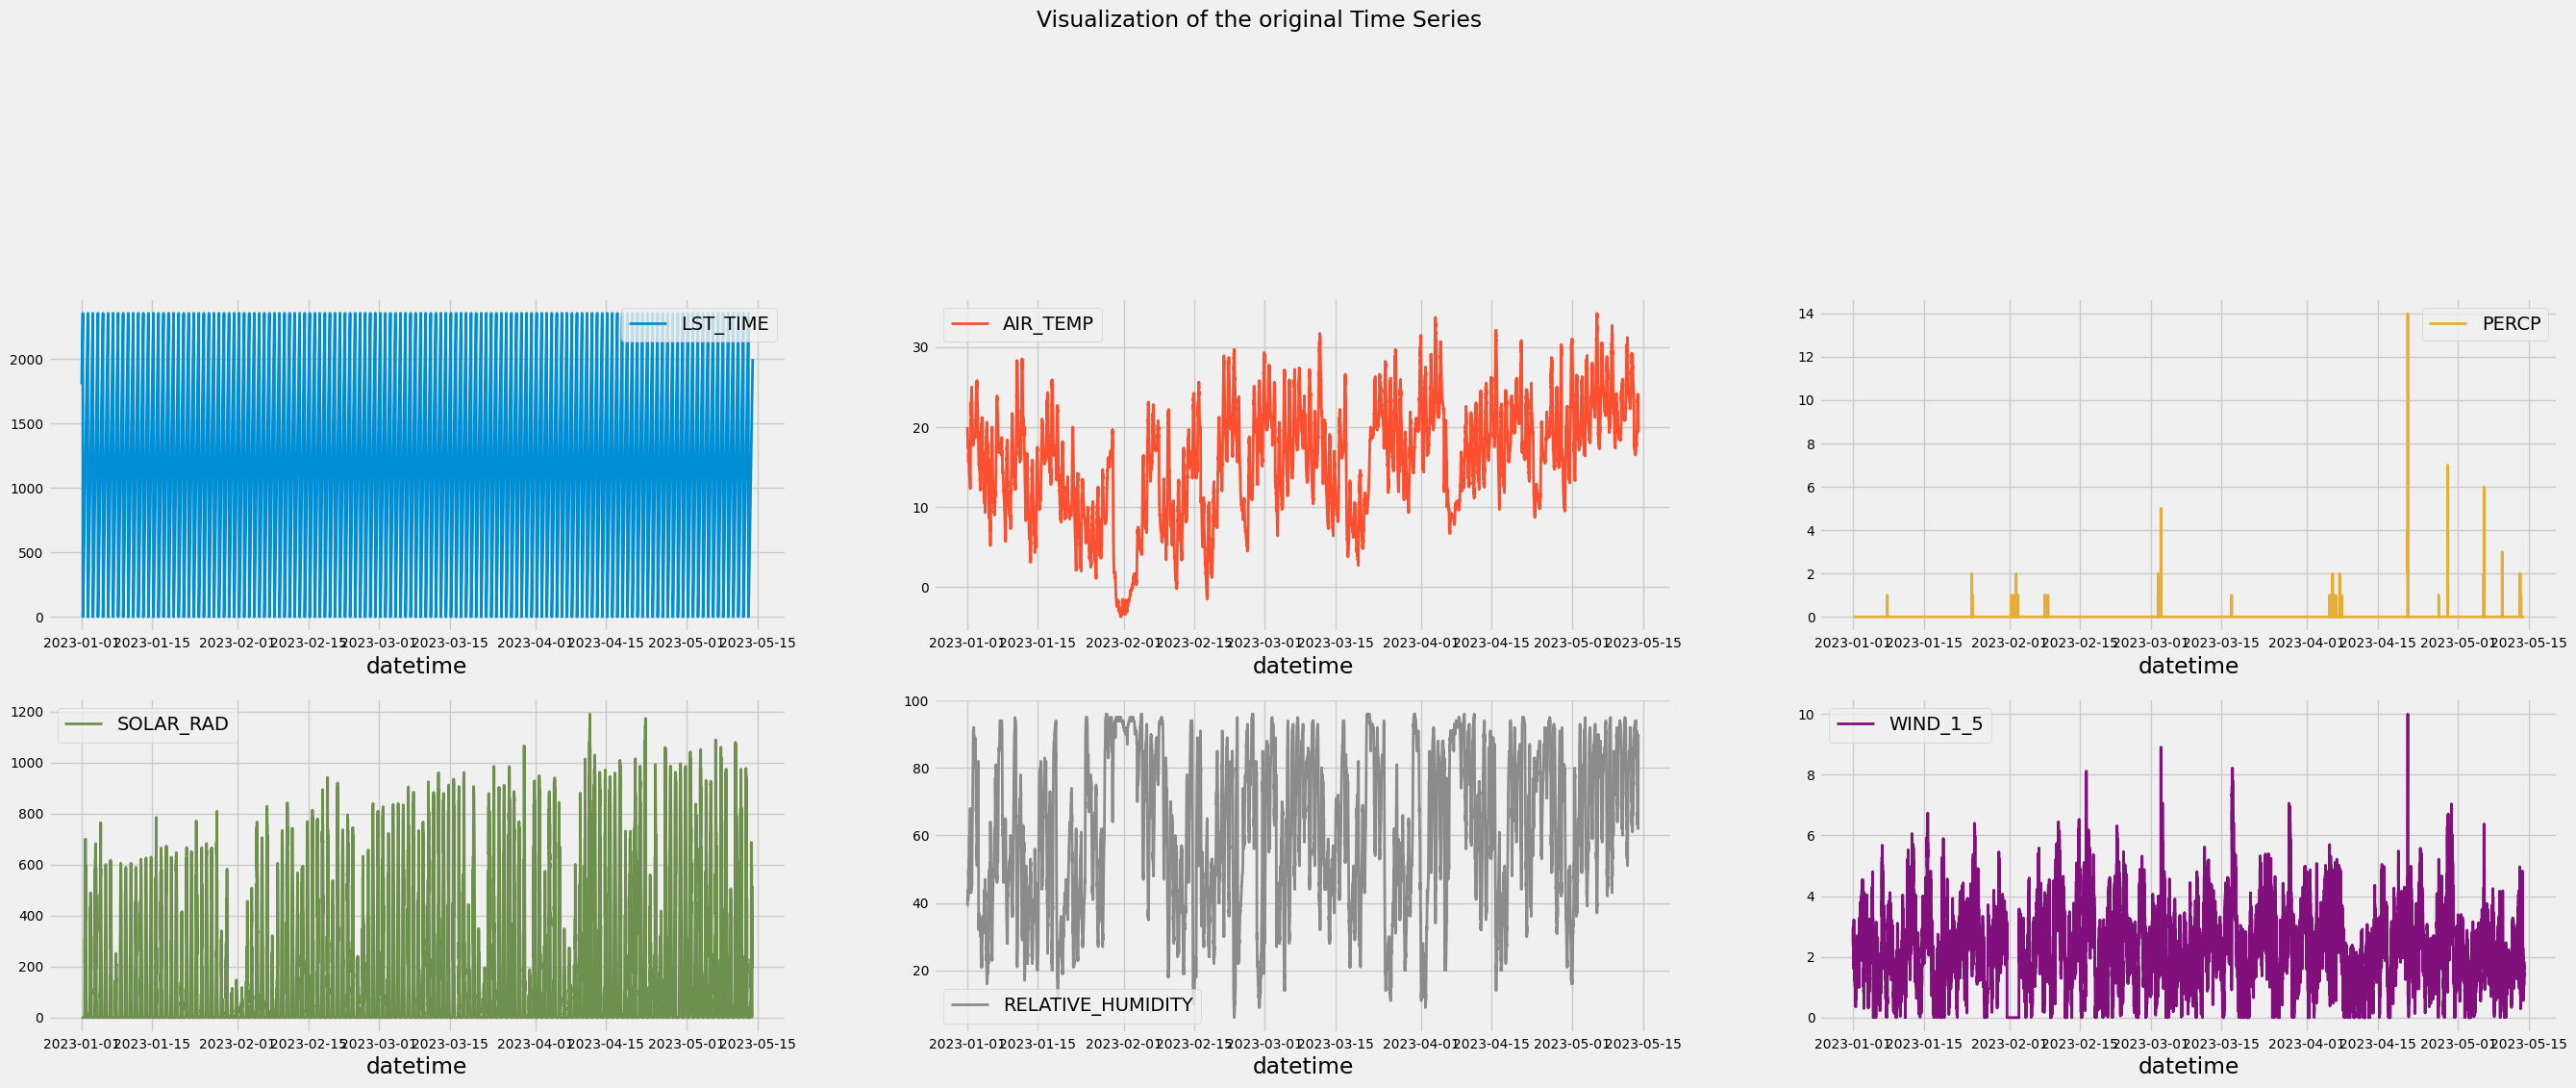

In [70]:
# Plot the time series
plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(30,30),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

downsample from data every 5 min to every 15 min

In [71]:
df = df.iloc[::3]
df

,LST_TIME,AIR_TEMP,PERCP,SOLAR_RAD,RELATIVE_HUMIDITY,WIND_1_5
datetime,,,,,,
2023-01-01 00:05:00,1805,20.0,0,0,39,2.94
2023-01-01 00:20:00,1820,19.7,0,0,40,2.99
2023-01-01 00:35:00,1835,19.4,0,0,40,2.53
2023-01-01 00:50:00,1850,19.4,0,0,40,2.76
2023-01-01 01:05:00,1905,19.0,0,0,41,2.25
...,...,...,...,...,...,...
2023-05-14 00:50:00,1850,20.5,0,0,85,1.37
2023-05-14 01:05:00,1905,20.2,0,0,87,1.68
2023-05-14 01:20:00,1920,19.8,0,0,89,1.67


1000 (12755, 6)


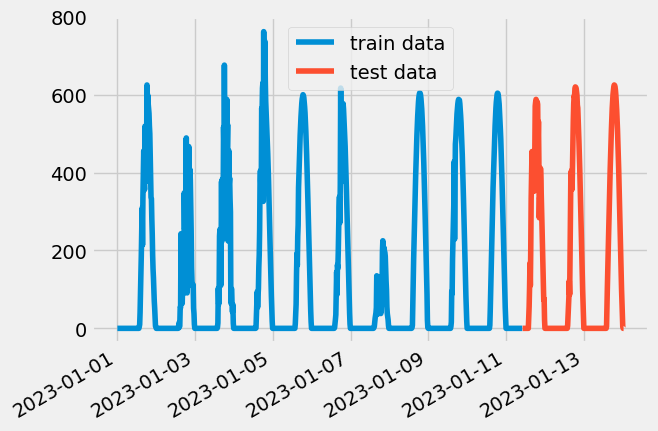

In [72]:
# training_size = int ( 0.05 * df.shape[0])  
training_size = 1000
print(training_size, df.shape)
train_data = df.iloc[:training_size]
val_data = df.iloc[training_size:training_size+training_size//4]
plt.plot(train_data.index, train_data[['SOLAR_RAD']], label = 'train data')
plt.plot(val_data.index, val_data[['SOLAR_RAD']], label='test data')
plt.legend()
plt.gcf().autofmt_xdate()

In [73]:
3*24*4

288

In [85]:
# split the data into inputs and targets
freq = 15            # 1 point every 15 min
step = int(60/freq)    # number of points in an hour
past = 3*24*step    # will be using last 3 days of data
future = 1*24*step  # to predict next 1 day


# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = past  # my choice of the timesteps window
pred_T = future
def create_batches(train_data, val_data, T, pred_T, feature_name):
    train_features, train_labels  = train_data.drop(feature_name,axis=1), train_data[[feature_name]]
    test_features, test_labels = val_data.drop(feature_name,axis=1), val_data[[feature_name]]

    prepend_features = train_features.iloc[-(T-1):]
    test_features = pd.concat([prepend_features, test_features], axis=0)

    print(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)


    # Create sequences of T timesteps (=sliding window)
    # Normalize sequences X = X/X_0-1, where X_0 is 1st timestep in the window:
    X_train, y_train = [], []
    for i in range(train_labels.shape[0] - (T+pred_T-1)):
        X_train.append(train_features.iloc[i:i+T])
        y_train.append(train_labels.iloc[i + (T-1):i + (T-1)+pred_T])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

    X_test, y_test = [], []
    for i in range(test_labels.shape[0]-pred_T):
        X_test.append(test_features.iloc[i:i+T])
        y_test.append(test_labels.iloc[i:i+pred_T])
    X_test, y_test = np.array(X_test), np.array(y_test)
    print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')
    y_train = y_train.reshape(-1,future)
    y_test = y_test.reshape(-1,future)

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    # X_train = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    # y_train = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape).reshape(-1,future)

    # X_test= scaler_x.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    # y_test= scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape).reshape(-1,future)

    print(f'(after normalisation) y data dimensions: {y_test.shape}, {y_train.shape}')

    return X_train, y_train, X_test, y_test, test_labels, scaler_x, scaler_y

X_train, y_train, X_test, y_test, test_labels, scaler_x, scaler_y = create_batches(train_data, val_data, T, pred_T, 'SOLAR_RAD')
print(type(X_train), type(y_train))

(1000, 5) (1000, 1) (537, 5) (250, 1)
Train data dimensions: (617, 288, 5), (617, 96, 1)
Test data dimensions: (154, 288, 5), (154, 96, 1)
(after normalisation) y data dimensions: (154, 96), (617, 96)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [75]:
T

288

layers=[192, 48, 96, 96], train_examples=617, test_examples=154
batch = 512, timesteps = 288, features = 5, epochs = 120
lr = 0.01, lambda = 0.05, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 192)               152064    
                                                                 
 dense_18 (Dense)            (None, 96)                18528     
                                                                 
Total params: 170,592
Trainable params: 170,592
Non-trainable params: 0
_________________________________________________________________


d:\mukul\anaconda3\envs\SOML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
-----------------------------------------------------------------
Training was completed in 437.96 secs
-----------------------------------------------------------------
1/1 [==============================] - 0s 490ms/step - loss: 0.7844 - accuracy: 0.0260
-----------------------------------------------------------------
train accuracy = 7.51%
fixed model test score = 2.6%


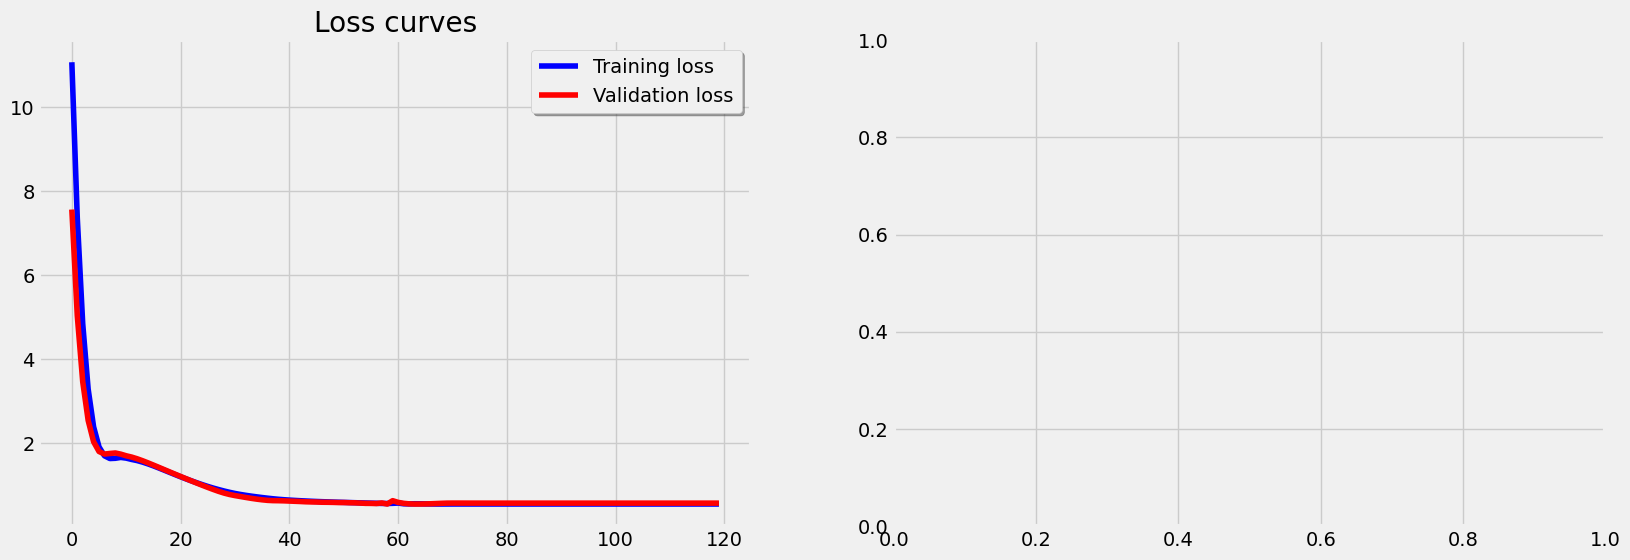

average solar error: 31.873589708691554
 mse: 26883.443203741874


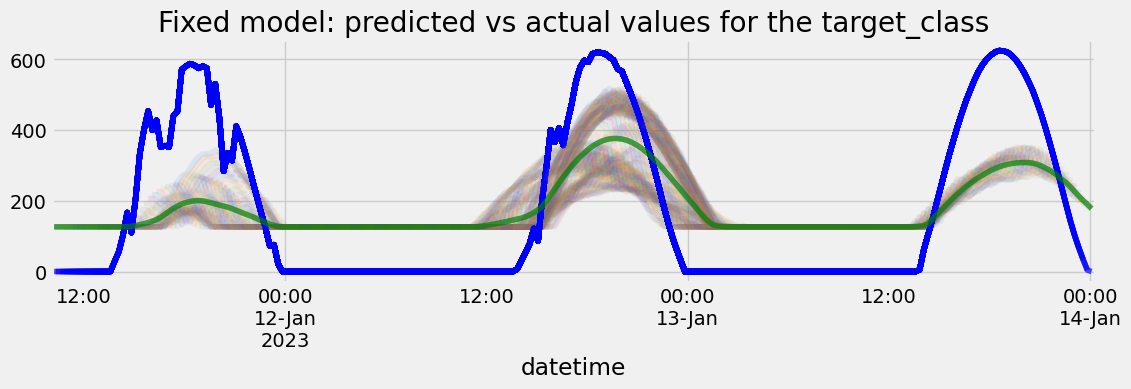

In [86]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [future*2, future//2, future, future]             # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = 512                        # batch size
EPOCH = 120                          # number of epochs
LR = 1e-2                            # learning rate of the gradient descent
LAMBD = 5e-2                         # lambda in L2 regularizaion
DP = 0.00                            # dropout rate
RDP = 0.00                           # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T,N), units=LAYERS[0],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=False, return_state=False,
            stateful=False, unroll=False))
# model.add(LSTM(units=LAYERS[1],
#             activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=True, return_state=False,
#             stateful=False, unroll=False))
# model.add(BatchNormalization())
# model.add(LSTM(units=LAYERS[2],
#             activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=False, return_state=False,
#             stateful=False, unroll=False))
model.add(Dense(units=LAYERS[3], activation = 'relu'))

# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=32, activation='relu', input_shape=(T,N)))
# model.add(LSTM(units=LAYERS[0],
#             activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=False, return_state=False,
#             stateful=False, unroll=False))
# # model.add(LSTM(units=LAYERS[1],
# #             activation='tanh', recurrent_activation='hard_sigmoid',
# #             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
# #             dropout=DP, recurrent_dropout=RDP,
# #             return_sequences=True, return_state=False,
# #             stateful=False, unroll=False))
# # model.add(LSTM(units=LAYERS[2],
# #             activation='tanh', recurrent_activation='hard_sigmoid',
# #             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
# #             dropout=DP, recurrent_dropout=RDP,
# #             return_sequences=False, return_state=False,
# #             stateful=False, unroll=False))
# model.add(Dense(units=LAYERS[3], activation='relu'))

# Compile the model with Adam optimizer
model.compile(loss='mse', metrics=['accuracy'],
            optimizer=Adam(lr=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', patience=1, verbose=0, 
                            factor=0.5, min_lr=1e-8)
start = time()
History = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,
                    validation_split=0.2, shuffle=True,verbose=0, callbacks=[lr_decay])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_acc = History.history['accuracy'][-1]    #model.evaluate(X_train, y_train, batch_size=M_TRAIN)
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=M_TEST)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 2)}%')
print(f'fixed model test score = {round(test_acc * 100, 2)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
plt.show()

# Plot predictions vs actual labels for fixed model

## for large amount
fixed_predict = model.predict_on_batch(X_test)
j = 0
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Fixed model: predicted vs actual values for the target_class')
dff_avg = pd.DataFrame({'predicted':  np.full(test_labels.shape[0], np.nan)},index=test_labels.index)
avg_temperr=0
avg_mse=0
for i in range(fixed_predict.shape[0]):
    averaged = scaler_y.inverse_transform(fixed_predict)[i]
    # Plot predictions vs actual labels for fixed model
    actual = scaler_y.inverse_transform(y_test)[i]
    index = test_labels.iloc[i:i+actual.shape[0]].index

    # print(fixed_predict)
    dff1 = pd.DataFrame({f'predicted': averaged.squeeze()}, index=index)
  
    # Assuming dff1 and dff2 are two dataframes with different index lengths
    # Join the two dataframes on their index
    dff_avg = dff_avg.join(dff1, how='left', rsuffix=f'_{i}')
    dff2 = pd.DataFrame({'actual': actual.squeeze()}, index=index)
    dff1.plot(ax=ax, alpha=0.1, legend=False)
    dff2.plot(ax=ax, alpha=0.7, color='blue', legend=False)
    avg_temperr +=np.mean(dff1['predicted']-dff2['actual'])
    avg_mse +=mean_squared_error(dff1['predicted'], dff2['actual'])
dff_avg= dff_avg.mean(axis=1)
dff_avg.plot(ax=ax, alpha=0.7, color='green', legend=False)
print(f"average solar error: {avg_temperr/fixed_predict.shape[0]}")
print(f" mse: {avg_mse/fixed_predict.shape[0]}")
plt.show()



Online model training and evaluation

d:\mukul\anaconda3\envs\SOML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Online model instantiated in 0.18 secs
Online learning completed in 56.28 secs
(154, 96)
(250,)
average cum solar error: -51.38262638261994
 cum mse: 44893.57123936773
mean temp error:  -75.79729059743083 mse:  49673.27196202659


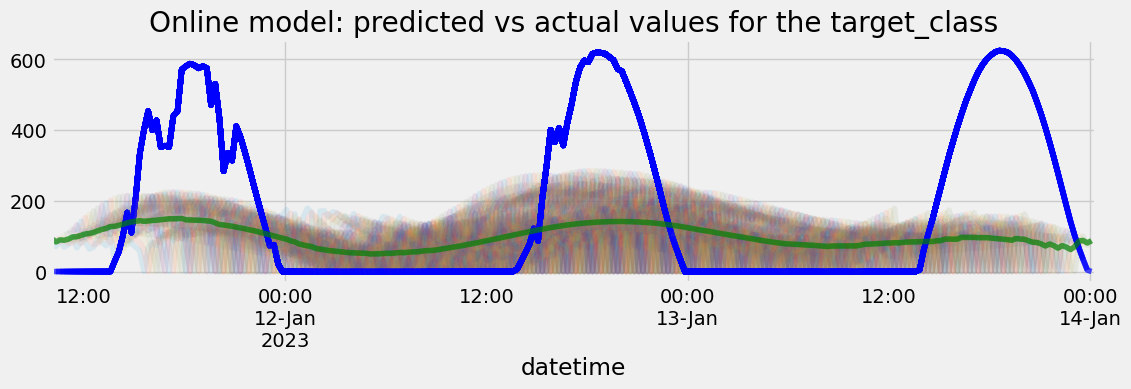

In [81]:
start = time()
config, weights = model.get_config(), model.get_weights()
online_model = Sequential.from_config(config)
online_model.set_weights(weights)
online_model.compile(loss='mse', optimizer=Adam(lr=LR))
print(f'Online model instantiated in {time() - start:.2f} secs')

# Online training (update model with each new data available):
predictions = []
start = time()
online_len = y_test.shape[0]
for t in range(online_len):
    x = X_test[t].reshape(-1,T,N)  # a "new" input is available
    y_hat = model.predict_on_batch(x) # predict on the "new" input
    # averaged = np.mean(y_hat[:,3:6,:], axis=1)
    predictions.append(y_hat)  # save predictions
    y = y_test[t].reshape(1,-1,1)   # a "new" label is available
    model.train_on_batch(x, y)  # runs a single gradient update 
print(f'Online learning completed in {time() - start:.2f} secs')



## for large amount
fixed_predict = np.array(predictions)
fixed_predict = fixed_predict.reshape(fixed_predict.shape[0],-1)
print(fixed_predict.shape)
j = 0
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Online model: predicted vs actual values for the target_class')
dff_avg = pd.DataFrame({'predicted':  np.full(test_labels.shape[0], np.nan)},index=test_labels.index)
dff_actual = pd.DataFrame({'actual':  np.array(test_labels).reshape(-1)},index=test_labels.index)
avg_temperr=0
avg_mse=0
j=0
for i in range(online_len):
    averaged = scaler_y.inverse_transform(fixed_predict)[i]
    # Plot predictions vs actual labels for fixed model
    actual = scaler_y.inverse_transform(y_test)[i]
    index = test_labels.iloc[i:i+actual.shape[0]].index

    # print(fixed_predict)
    dff1 = pd.DataFrame({'predicted': averaged.squeeze()}, index=index)
    j+=1
    # Assuming dff1 and dff2 are two dataframes with different index lengths
    # Join the two dataframes on their index
    dff_avg = dff_avg.join(dff1, how='left', rsuffix=f'_{i}')
    dff2 = pd.DataFrame({'actual': actual.squeeze()}, index=index)
    dff1.plot(ax=ax, alpha=0.1, legend=False)
    dff2.plot(ax=ax, alpha=0.7, color='blue', legend=False)
    avg_temperr +=np.mean(dff1['predicted']-dff2['actual'])
    avg_mse +=mean_squared_error(dff1['predicted'], dff2['actual'])
dff_avg= dff_avg.mean(axis=1)
print(dff_avg.values.shape)
dff_avg.plot(ax=ax, alpha=0.7, color='green')
print(f"average cum solar error: {avg_temperr/fixed_predict.shape[0]}")
print(f" cum mse: {avg_mse/fixed_predict.shape[0]}")

dff_avg_arry = np.array(dff_avg.values).reshape(-1)
dff_actual_arry = np.array(dff_actual['actual']).reshape(-1)[~np.isnan(dff_avg_arry)]
dff_avg_arry = dff_avg_arry[~np.isnan(dff_avg_arry)]
diff = (dff_avg_arry-dff_actual_arry)
dff_mse = mean_squared_error(dff_avg_arry, dff_actual_arry)
print("mean temp error: ", np.mean(diff), "mse: ", dff_mse)
plt.show()
